# 서울시 편의점 매출 결정요인 분석
## 03_1. 심화 시각화

---

### 이 노트북의 목표
03_시각화.ipynb의 기본 시각화에 더해, 더 다양하고 심층적인 시각화 제공

### 추가 시각화 구성
1. 매출 분포 심화 (KDE, 로그 변환)
2. 구별 매출 현황 (지역별 분석)
3. 상권유형별 세부 분석 (바이올린 플롯, 스웜 플롯)
4. 다변량 분석 (페어플롯, 3D 산점도)
5. 시계열 심화 (분기별 성장률, 계절성)
6. 점포 효율성 분석
7. 유동인구 구간별 분석
8. 인터랙티브 요소 (분포 비교)

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 색상 팔레트
colors = {'골목상권': '#4E79A7', '발달상권': '#F28E2B', '전통시장': '#59A14F', 
          '관광특구': '#E15759', '미분류': '#B07AA1'}

import os
os.makedirs('./outputs', exist_ok=True)

# 데이터 로드
df = pd.read_csv('./분석데이터.csv', encoding='utf-8-sig')
print(f"데이터 로드: {len(df):,}건")

데이터 로드: 6,097건


## 1. 매출 분포 심화 분석

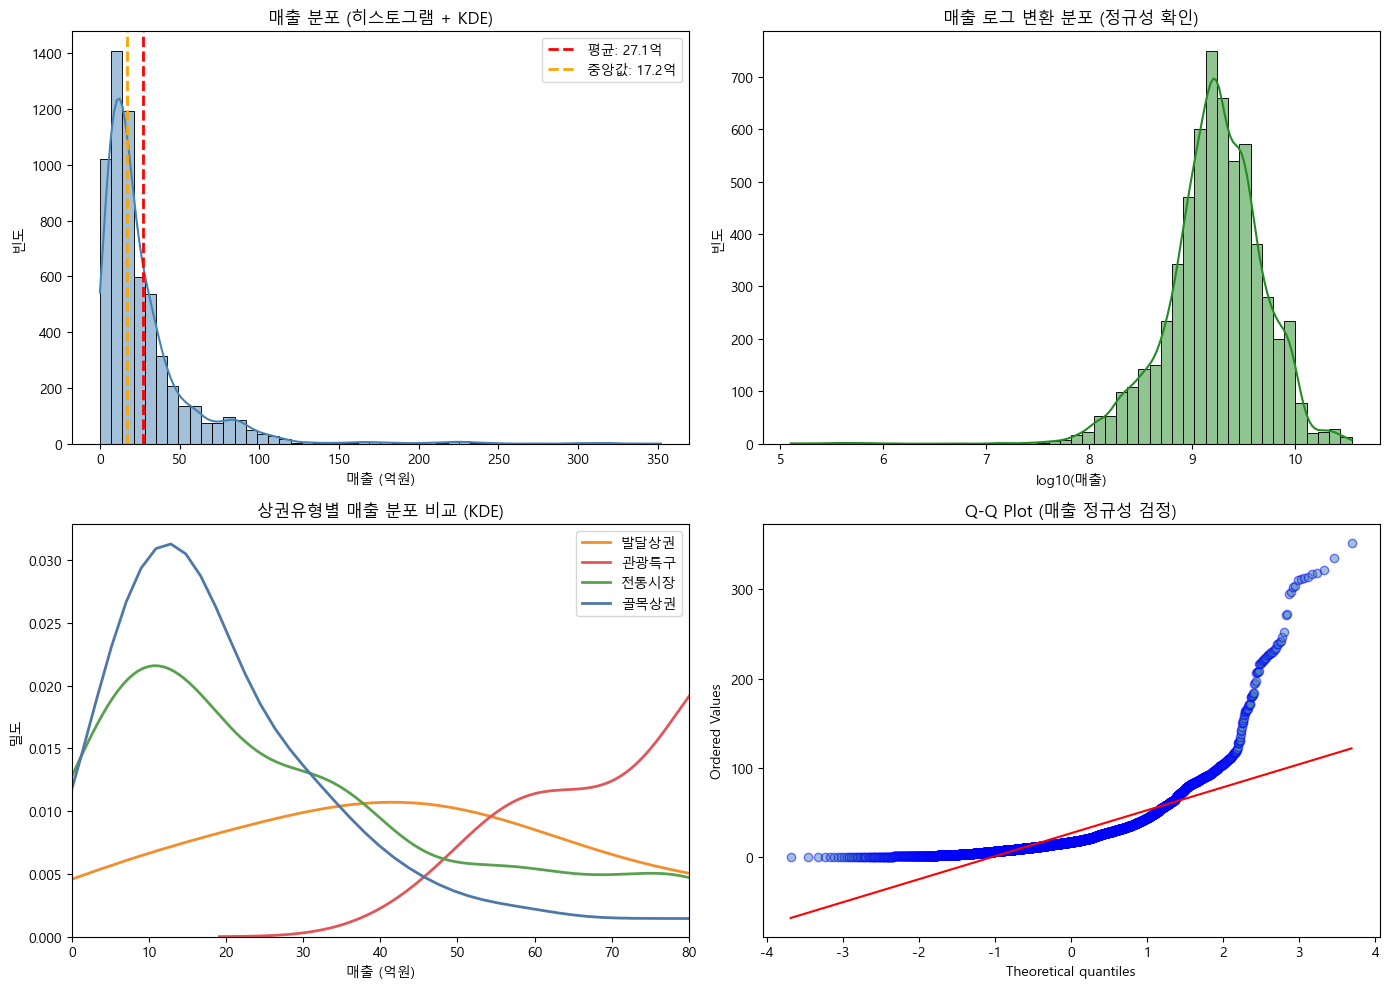

→ 로그 변환 시 정규분포에 가까워짐
→ 상권유형별 분포 형태가 다름 (발달상권이 가장 넓게 퍼짐)


In [2]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1-1. 히스토그램 + KDE
ax1 = axes[0, 0]
sns.histplot(df['당월_매출_금액']/1e8, bins=50, kde=True, color='steelblue', ax=ax1)
ax1.axvline(df['당월_매출_금액'].mean()/1e8, color='red', linestyle='--', linewidth=2, label=f"평균: {df['당월_매출_금액'].mean()/1e8:.1f}억")
ax1.axvline(df['당월_매출_금액'].median()/1e8, color='orange', linestyle='--', linewidth=2, label=f"중앙값: {df['당월_매출_금액'].median()/1e8:.1f}억")
ax1.set_xlabel('매출 (억원)')
ax1.set_ylabel('빈도')
ax1.set_title('매출 분포 (히스토그램 + KDE)')
ax1.legend()

# 1-2. 로그 변환 분포
ax2 = axes[0, 1]
log_sales = np.log10(df['당월_매출_금액'])
sns.histplot(log_sales, bins=50, kde=True, color='forestgreen', ax=ax2)
ax2.set_xlabel('log10(매출)')
ax2.set_ylabel('빈도')
ax2.set_title('매출 로그 변환 분포 (정규성 확인)')

# 1-3. 상권유형별 KDE 비교
ax3 = axes[1, 0]
for t in ['발달상권', '관광특구', '전통시장', '골목상권']:
    subset = df[df['주요_상권유형'] == t]['당월_매출_금액']/1e8
    if len(subset) > 0:
        sns.kdeplot(subset, ax=ax3, label=t, color=colors[t], linewidth=2)
ax3.set_xlabel('매출 (억원)')
ax3.set_ylabel('밀도')
ax3.set_title('상권유형별 매출 분포 비교 (KDE)')
ax3.legend()
ax3.set_xlim(0, 80)

# 1-4. Q-Q Plot (정규성 검정)
ax4 = axes[1, 1]
stats.probplot(df['당월_매출_금액']/1e8, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (매출 정규성 검정)')
ax4.get_lines()[0].set_markerfacecolor('steelblue')
ax4.get_lines()[0].set_alpha(0.5)

plt.tight_layout()
plt.savefig('./outputs/A01_매출분포_심화.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 로그 변환 시 정규분포에 가까워짐")
print("→ 상권유형별 분포 형태가 다름 (발달상권이 가장 넓게 퍼짐)")

## 2. 구별 매출 현황

In [ ]:
# 행정동에서 구 추출
df['구'] = df['행정동_코드_명'].str.extract(r'^(\S+[구동])')[0]

# 가장 최근 분기만
latest_qtr = df['기준_년분기_코드'].max()
df_latest = df[df['기준_년분기_코드'] == latest_qtr]

# 구별 평균 매출
gu_sales = df_latest.groupby('구')['당월_매출_금액'].mean().sort_values(ascending=True) / 1e8

fig, ax = plt.subplots(figsize=(12, 10))

# 색상 그라데이션
colors_bar = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(gu_sales)))

bars = ax.barh(gu_sales.index, gu_sales.values, color=colors_bar, edgecolor='black', alpha=0.8)

# 평균선
avg = gu_sales.mean()
ax.axvline(avg, color='red', linestyle='--', linewidth=2, label=f'전체 평균: {avg:.1f}억')

# 값 표시
for bar, val in zip(bars, gu_sales.values):
    ax.text(val + 0.3, bar.get_y() + bar.get_height()/2, f'{val:.1f}', 
            va='center', fontsize=9)

ax.set_xlabel('평균 매출 (억원)', fontsize=12)
ax.set_title(f'행정동별 평균 편의점 매출 ({latest_qtr//10}년 {latest_qtr%10}분기)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/A02_구별_매출.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"→ 최고: {gu_sales.idxmax()} ({gu_sales.max():.1f}억)")
print(f"→ 최저: {gu_sales.idxmin()} ({gu_sales.min():.1f}억)")

## 3. 상권유형별 세부 분석

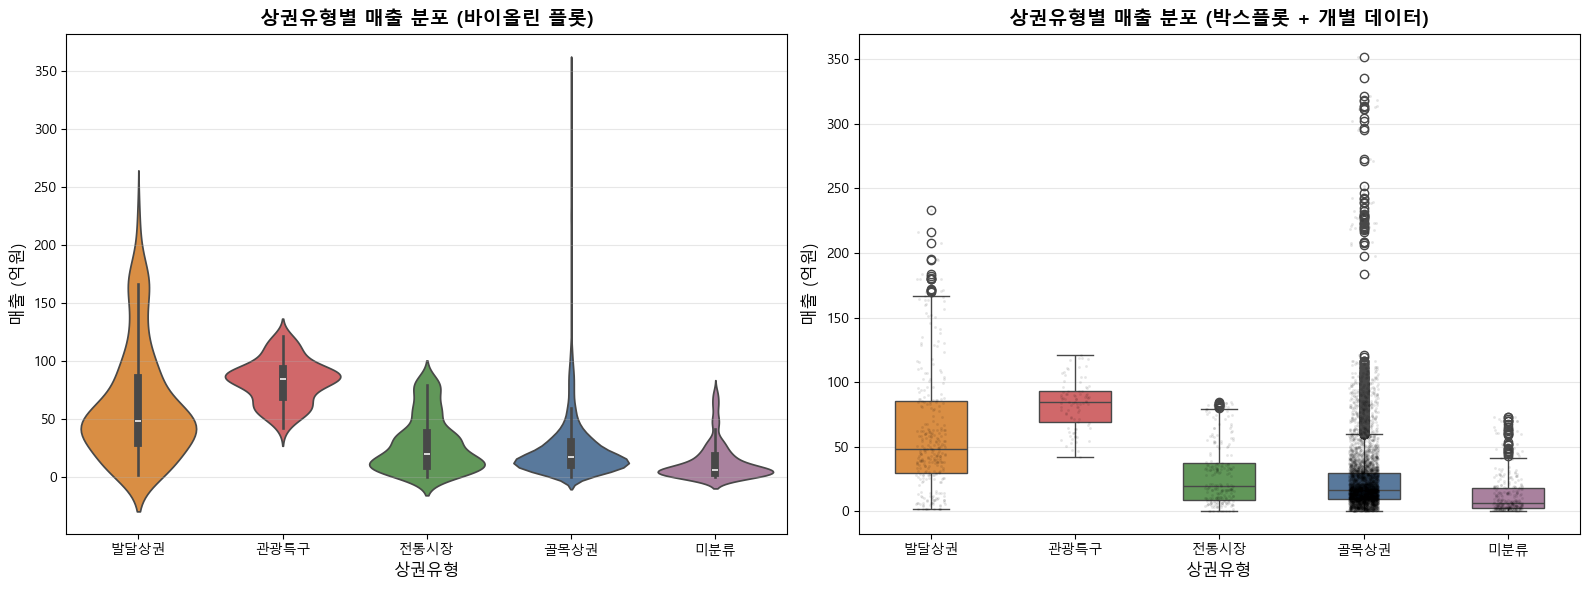

→ 발달상권: 분포가 넓고 고매출 이상치 많음
→ 골목상권: 분포가 좁고 매출이 집중됨


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 상권유형 순서
type_order = ['발달상권', '관광특구', '전통시장', '골목상권', '미분류']
type_order = [t for t in type_order if t in df['주요_상권유형'].values]

# 3-1. 바이올린 플롯
ax1 = axes[0]
palette = [colors[t] for t in type_order]
sns.violinplot(data=df, x='주요_상권유형', y=df['당월_매출_금액']/1e8, 
               order=type_order, palette=palette, ax=ax1)
ax1.set_xlabel('상권유형', fontsize=12)
ax1.set_ylabel('매출 (억원)', fontsize=12)
ax1.set_title('상권유형별 매출 분포 (바이올린 플롯)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 3-2. 스트립 플롯 + 박스플롯 조합
ax2 = axes[1]
sns.boxplot(data=df, x='주요_상권유형', y=df['당월_매출_금액']/1e8, 
            order=type_order, palette=palette, ax=ax2, width=0.5)
sns.stripplot(data=df, x='주요_상권유형', y=df['당월_매출_금액']/1e8, 
              order=type_order, color='black', alpha=0.1, size=2, ax=ax2)
ax2.set_xlabel('상권유형', fontsize=12)
ax2.set_ylabel('매출 (억원)', fontsize=12)
ax2.set_title('상권유형별 매출 분포 (박스플롯 + 개별 데이터)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/A03_상권유형_바이올린.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 발달상권: 분포가 넓고 고매출 이상치 많음")
print("→ 골목상권: 분포가 좁고 매출이 집중됨")

## 4. 다변량 관계 분석

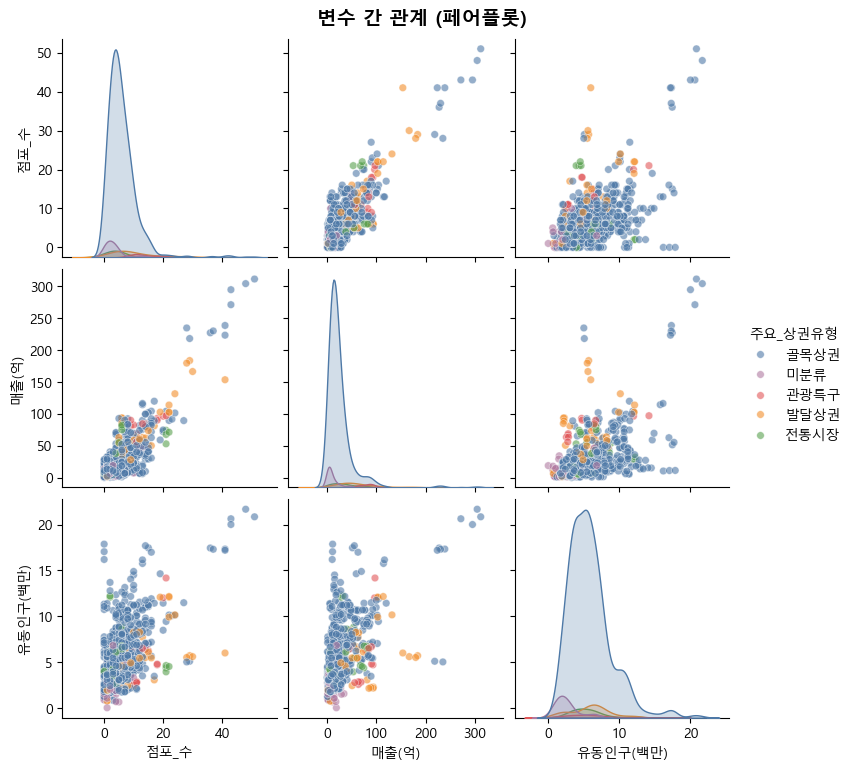

In [5]:
# 샘플링 (전체 데이터로 하면 너무 오래 걸림)
df_sample = df.sample(min(1000, len(df)), random_state=42)

# 페어플롯
plot_df = df_sample[['당월_매출_금액', '점포_수', '총_유동인구_수', '주요_상권유형']].copy()
plot_df['매출(억)'] = plot_df['당월_매출_금액'] / 1e8
plot_df['유동인구(백만)'] = plot_df['총_유동인구_수'] / 1e6
plot_df = plot_df.drop(columns=['당월_매출_금액', '총_유동인구_수'])

g = sns.pairplot(plot_df, hue='주요_상권유형', palette=colors, 
                 diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
g.fig.suptitle('변수 간 관계 (페어플롯)', y=1.02, fontsize=14, fontweight='bold')

plt.savefig('./outputs/A04_페어플롯.png', dpi=150, bbox_inches='tight')
plt.show()

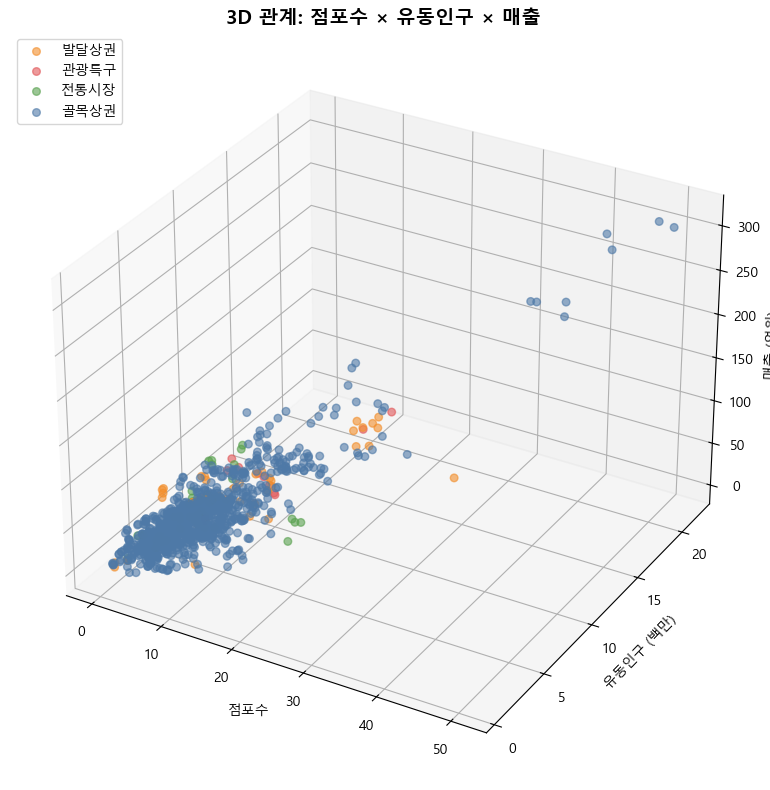

In [6]:
# 3D 산점도
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for t in ['발달상권', '관광특구', '전통시장', '골목상권']:
    subset = df_sample[df_sample['주요_상권유형'] == t]
    ax.scatter(subset['점포_수'], 
               subset['총_유동인구_수']/1e6,
               subset['당월_매출_금액']/1e8,
               c=colors[t], label=t, alpha=0.6, s=30)

ax.set_xlabel('점포수')
ax.set_ylabel('유동인구 (백만)')
ax.set_zlabel('매출 (억원)')
ax.set_title('3D 관계: 점포수 × 유동인구 × 매출', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('./outputs/A05_3D_산점도.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. 시계열 심화 분석

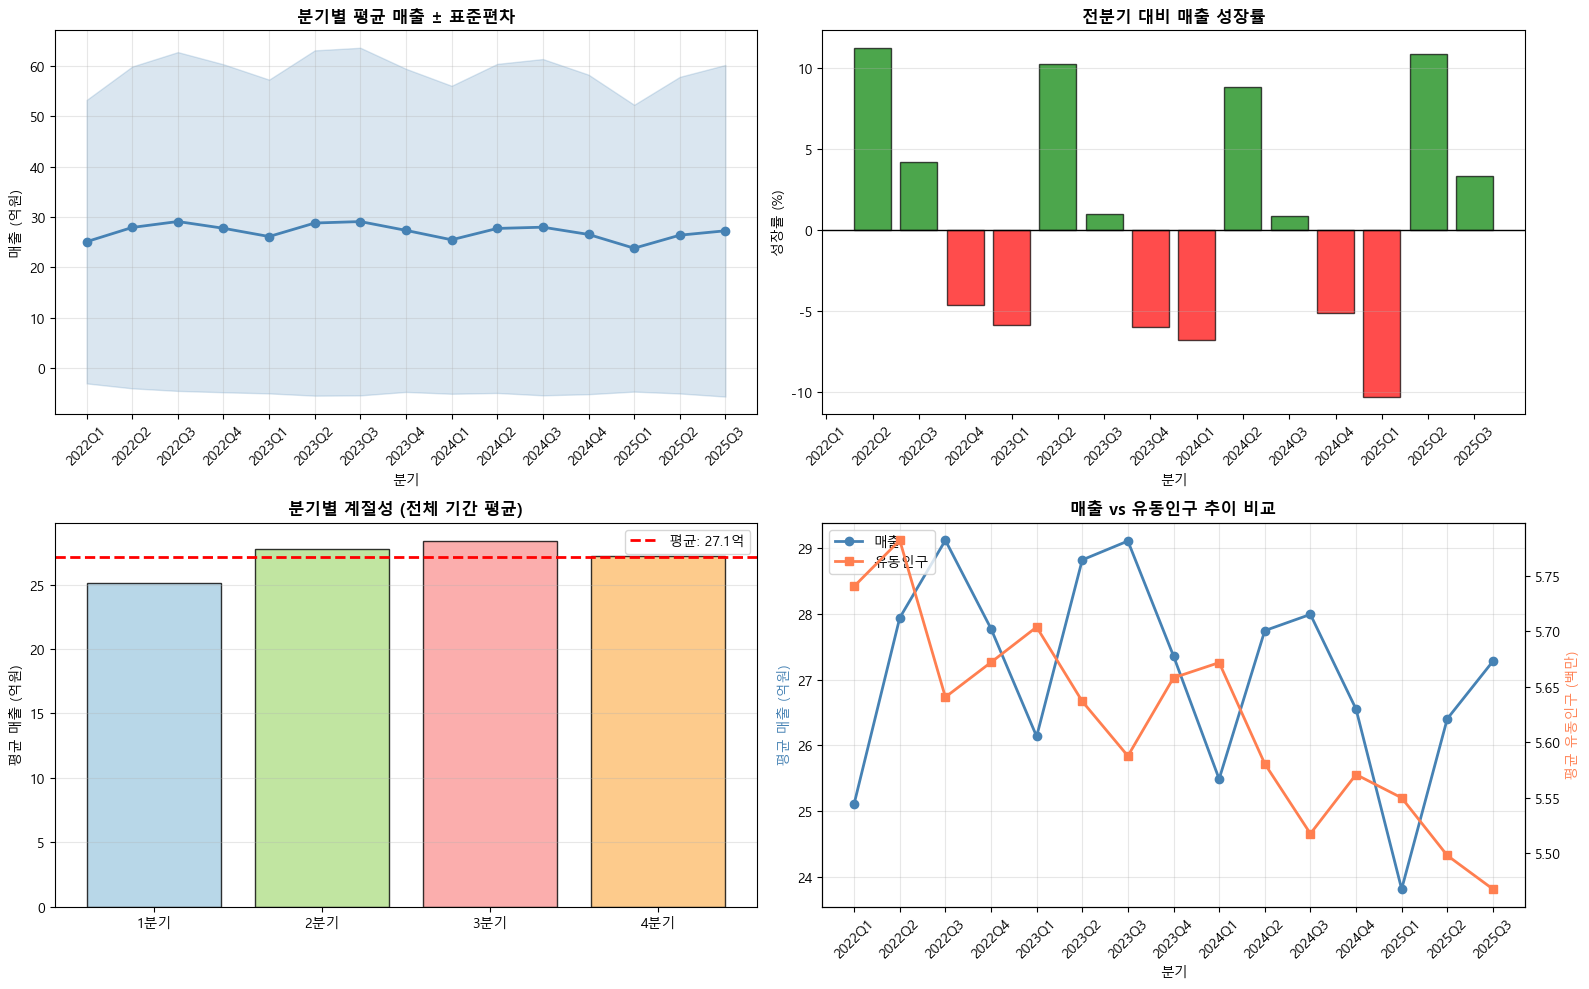

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 분기별 집계
quarterly = df.groupby('기준_년분기_코드').agg({
    '당월_매출_금액': ['mean', 'sum', 'std'],
    '점포_수': 'mean',
    '총_유동인구_수': 'mean'
}).reset_index()
quarterly.columns = ['분기', '평균매출', '총매출', '매출표준편차', '평균점포', '평균유동인구']
labels = [f"{q//10}Q{q%10}" for q in quarterly['분기']]

# 5-1. 평균 매출 + 표준편차 밴드
ax1 = axes[0, 0]
mean_sales = quarterly['평균매출'] / 1e8
std_sales = quarterly['매출표준편차'] / 1e8
ax1.plot(labels, mean_sales, marker='o', linewidth=2, color='steelblue', label='평균 매출')
ax1.fill_between(labels, mean_sales - std_sales, mean_sales + std_sales, alpha=0.2, color='steelblue')
ax1.set_xlabel('분기')
ax1.set_ylabel('매출 (억원)')
ax1.set_title('분기별 평균 매출 ± 표준편차', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.3)

# 5-2. 전분기 대비 성장률
ax2 = axes[0, 1]
growth = quarterly['평균매출'].pct_change() * 100
colors_growth = ['green' if x >= 0 else 'red' for x in growth]
ax2.bar(labels, growth, color=colors_growth, alpha=0.7, edgecolor='black')
ax2.axhline(0, color='black', linewidth=1)
ax2.set_xlabel('분기')
ax2.set_ylabel('성장률 (%)')
ax2.set_title('전분기 대비 매출 성장률', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# 5-3. 계절성 분석 (분기별 평균)
ax3 = axes[1, 0]
df['분기만'] = df['기준_년분기_코드'] % 10
seasonal = df.groupby('분기만')['당월_매출_금액'].mean() / 1e8
ax3.bar(['1분기', '2분기', '3분기', '4분기'][:len(seasonal)], seasonal.values, 
        color=['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f'][:len(seasonal)], 
        edgecolor='black', alpha=0.8)
ax3.axhline(seasonal.mean(), color='red', linestyle='--', linewidth=2, label=f'평균: {seasonal.mean():.1f}억')
ax3.set_ylabel('평균 매출 (억원)')
ax3.set_title('분기별 계절성 (전체 기간 평균)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 5-4. 매출 vs 유동인구 시계열
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

ax4.plot(labels, quarterly['평균매출']/1e8, marker='o', color='steelblue', linewidth=2, label='매출')
ax4_twin.plot(labels, quarterly['평균유동인구']/1e6, marker='s', color='coral', linewidth=2, label='유동인구')

ax4.set_xlabel('분기')
ax4.set_ylabel('평균 매출 (억원)', color='steelblue')
ax4_twin.set_ylabel('평균 유동인구 (백만)', color='coral')
ax4.set_title('매출 vs 유동인구 추이 비교', fontsize=12, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(alpha=0.3)

# 범례 통합
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('./outputs/A06_시계열_심화.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 점포 효율성 분석

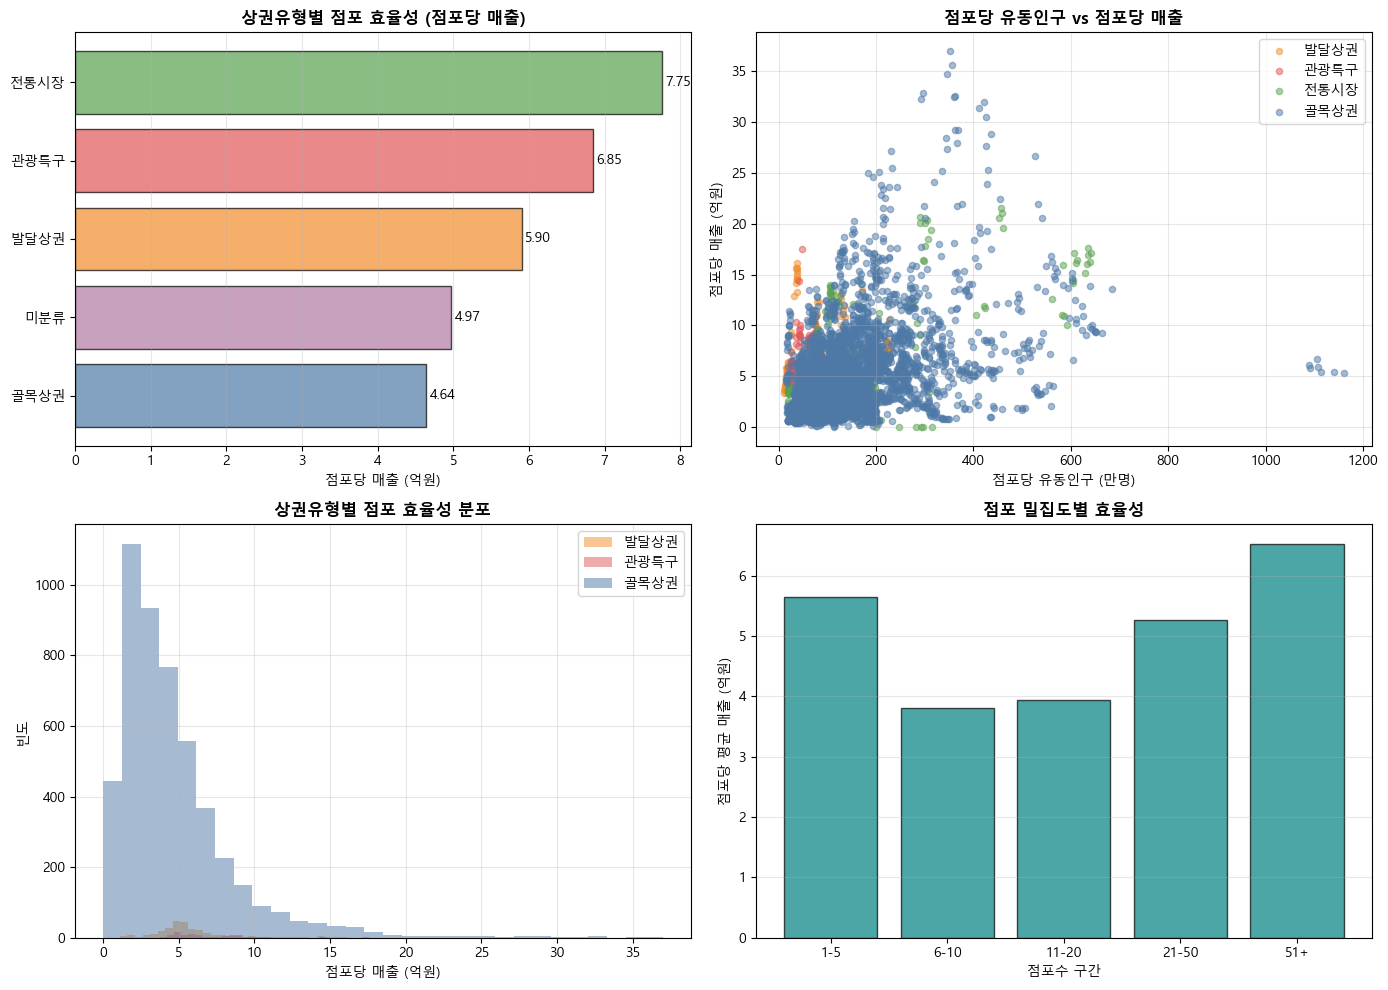

→ 점포당 매출은 발달상권이 가장 높음
→ 점포 밀집도가 높아지면 효율성은 오히려 감소 (경쟁 효과)


In [8]:
# 점포당 매출 계산
df['점포당_매출'] = df['당월_매출_금액'] / df['점포_수'].replace(0, np.nan)
df['점포당_유동인구'] = df['총_유동인구_수'] / df['점포_수'].replace(0, np.nan)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 6-1. 상권유형별 점포당 매출
ax1 = axes[0, 0]
efficiency = df.groupby('주요_상권유형')['점포당_매출'].mean().sort_values(ascending=True) / 1e8
bars = ax1.barh(efficiency.index, efficiency.values, color=[colors.get(t, 'gray') for t in efficiency.index], 
                edgecolor='black', alpha=0.7)
for bar, val in zip(bars, efficiency.values):
    ax1.text(val + 0.05, bar.get_y() + bar.get_height()/2, f'{val:.2f}', va='center')
ax1.set_xlabel('점포당 매출 (억원)')
ax1.set_title('상권유형별 점포 효율성 (점포당 매출)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 6-2. 점포당 유동인구 vs 점포당 매출
ax2 = axes[0, 1]
for t in ['발달상권', '관광특구', '전통시장', '골목상권']:
    subset = df[df['주요_상권유형'] == t]
    ax2.scatter(subset['점포당_유동인구']/1e4, subset['점포당_매출']/1e8, 
                c=colors[t], label=t, alpha=0.5, s=20)
ax2.set_xlabel('점포당 유동인구 (만명)')
ax2.set_ylabel('점포당 매출 (억원)')
ax2.set_title('점포당 유동인구 vs 점포당 매출', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 6-3. 효율성 분포 (히스토그램)
ax3 = axes[1, 0]
for t in ['발달상권', '관광특구', '골목상권']:
    subset = df[df['주요_상권유형'] == t]['점포당_매출'].dropna() / 1e8
    ax3.hist(subset, bins=30, alpha=0.5, label=t, color=colors[t])
ax3.set_xlabel('점포당 매출 (억원)')
ax3.set_ylabel('빈도')
ax3.set_title('상권유형별 점포 효율성 분포', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 6-4. 점포수 구간별 효율성
ax4 = axes[1, 1]
df['점포수_구간'] = pd.cut(df['점포_수'], bins=[0, 5, 10, 20, 50, 100], 
                        labels=['1-5', '6-10', '11-20', '21-50', '51+'])
store_eff = df.groupby('점포수_구간')['점포당_매출'].mean() / 1e8
ax4.bar(store_eff.index.astype(str), store_eff.values, color='teal', edgecolor='black', alpha=0.7)
ax4.set_xlabel('점포수 구간')
ax4.set_ylabel('점포당 평균 매출 (억원)')
ax4.set_title('점포 밀집도별 효율성', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/A07_점포효율성.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 점포당 매출은 발달상권이 가장 높음")
print("→ 점포 밀집도가 높아지면 효율성은 오히려 감소 (경쟁 효과)")

## 7. 유동인구 구간별 분석

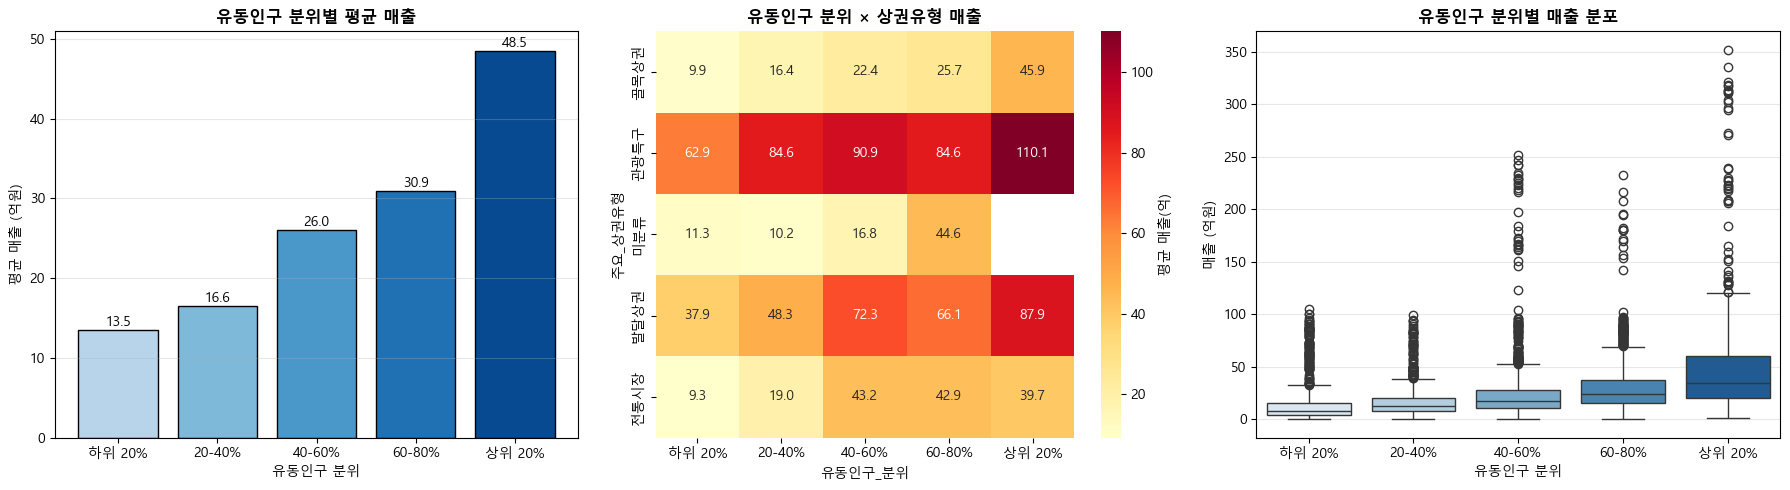

→ 유동인구 상위 20% 지역의 매출이 압도적으로 높음
→ 발달상권 + 상위 유동인구 조합이 최고 매출


In [9]:
# 유동인구 5분위 생성
df['유동인구_분위'] = pd.qcut(df['총_유동인구_수'], q=5, labels=['하위 20%', '20-40%', '40-60%', '60-80%', '상위 20%'])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 7-1. 유동인구 분위별 평균 매출
ax1 = axes[0]
pop_sales = df.groupby('유동인구_분위')['당월_매출_금액'].mean() / 1e8
colors_pop = plt.cm.Blues(np.linspace(0.3, 0.9, 5))
bars = ax1.bar(pop_sales.index.astype(str), pop_sales.values, color=colors_pop, edgecolor='black')
for bar, val in zip(bars, pop_sales.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', ha='center', fontsize=10)
ax1.set_xlabel('유동인구 분위')
ax1.set_ylabel('평균 매출 (억원)')
ax1.set_title('유동인구 분위별 평균 매출', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 7-2. 유동인구 분위 × 상권유형 히트맵
ax2 = axes[1]
pivot = df.pivot_table(values='당월_매출_금액', index='주요_상권유형', 
                       columns='유동인구_분위', aggfunc='mean') / 1e8
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2, cbar_kws={'label': '평균 매출(억)'})
ax2.set_title('유동인구 분위 × 상권유형 매출', fontsize=12, fontweight='bold')

# 7-3. 유동인구 구간별 매출 박스플롯
ax3 = axes[2]
sns.boxplot(data=df, x='유동인구_분위', y=df['당월_매출_금액']/1e8, palette='Blues', ax=ax3)
ax3.set_xlabel('유동인구 분위')
ax3.set_ylabel('매출 (억원)')
ax3.set_title('유동인구 분위별 매출 분포', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/A08_유동인구구간.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 유동인구 상위 20% 지역의 매출이 압도적으로 높음")
print("→ 발달상권 + 상위 유동인구 조합이 최고 매출")

## 8. 상관관계 심화 분석

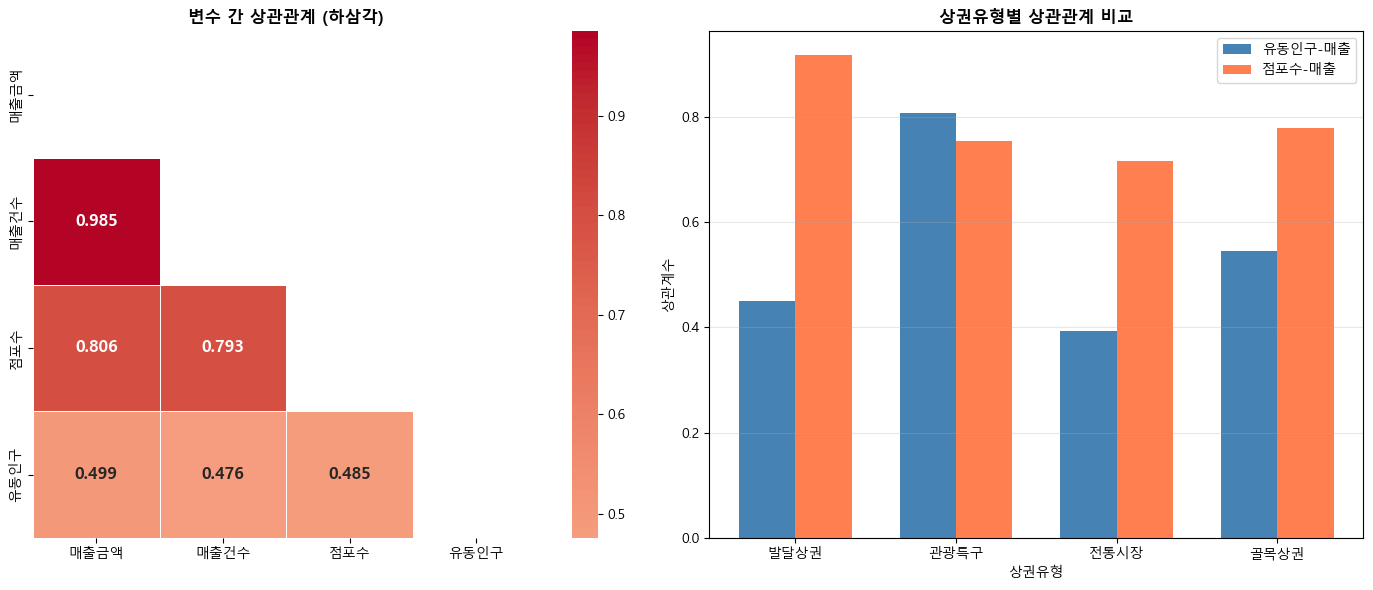

→ 매출금액과 매출건수는 거의 완벽한 상관 (당연)
→ 상권유형별로 상관관계 강도가 다름


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 8-1. 상관관계 히트맵 (수치형 변수)
ax1 = axes[0]
corr_cols = ['당월_매출_금액', '당월_매출_건수', '점포_수', '총_유동인구_수']
corr_matrix = df[corr_cols].corr()
corr_matrix.index = ['매출금액', '매출건수', '점포수', '유동인구']
corr_matrix.columns = ['매출금액', '매출건수', '점포수', '유동인구']

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            mask=mask, square=True, linewidths=0.5, 
            annot_kws={'size': 12, 'weight': 'bold'}, ax=ax1)
ax1.set_title('변수 간 상관관계 (하삼각)', fontsize=12, fontweight='bold')

# 8-2. 상권유형별 상관관계 비교
ax2 = axes[1]
corr_by_type = []
for t in ['발달상권', '관광특구', '전통시장', '골목상권']:
    subset = df[df['주요_상권유형'] == t]
    corr_pop = subset['당월_매출_금액'].corr(subset['총_유동인구_수'])
    corr_store = subset['당월_매출_금액'].corr(subset['점포_수'])
    corr_by_type.append({'상권': t, '유동인구-매출': corr_pop, '점포수-매출': corr_store})

corr_df = pd.DataFrame(corr_by_type)
x = np.arange(len(corr_df))
width = 0.35

bars1 = ax2.bar(x - width/2, corr_df['유동인구-매출'], width, label='유동인구-매출', color='steelblue')
bars2 = ax2.bar(x + width/2, corr_df['점포수-매출'], width, label='점포수-매출', color='coral')

ax2.set_xlabel('상권유형')
ax2.set_ylabel('상관계수')
ax2.set_title('상권유형별 상관관계 비교', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(corr_df['상권'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.savefig('./outputs/A09_상관관계_심화.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 매출금액과 매출건수는 거의 완벽한 상관 (당연)")
print("→ 상권유형별로 상관관계 강도가 다름")

## 9. 이상치 및 특이 지역 분석

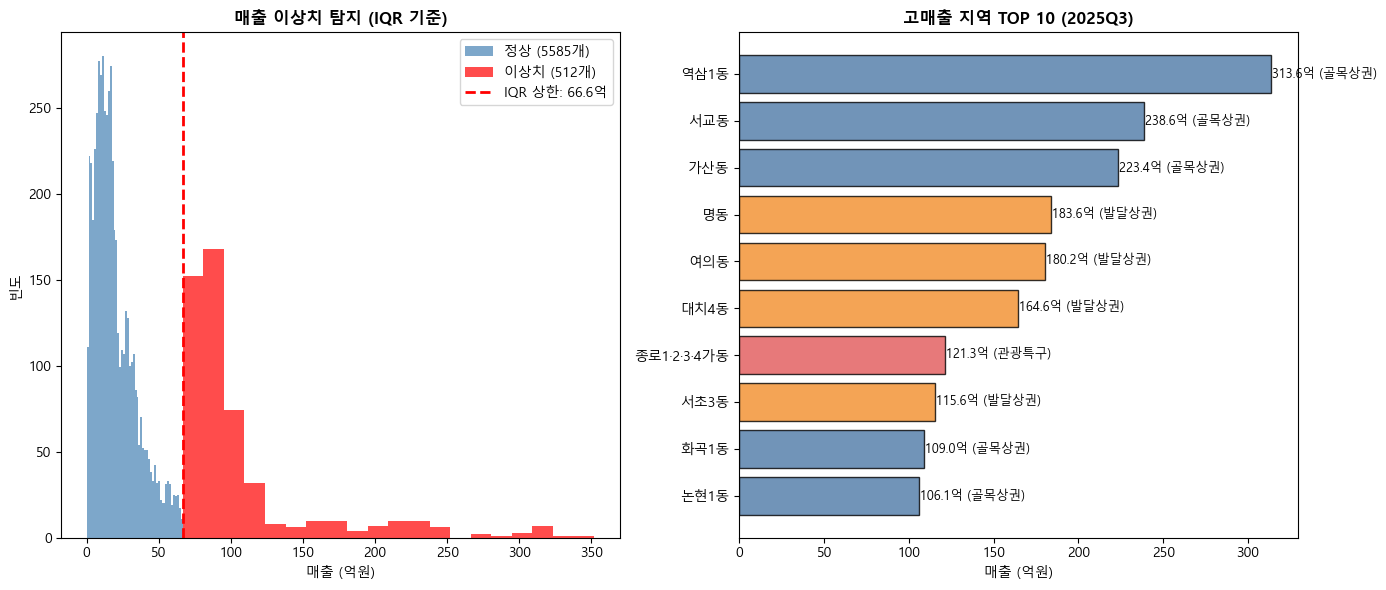

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 9-1. 매출 이상치 탐지 (IQR)
ax1 = axes[0]
Q1 = df['당월_매출_금액'].quantile(0.25)
Q3 = df['당월_매출_금액'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

normal = df[df['당월_매출_금액'] <= upper_bound]['당월_매출_금액'] / 1e8
outliers = df[df['당월_매출_금액'] > upper_bound]['당월_매출_금액'] / 1e8

ax1.hist(normal, bins=50, alpha=0.7, color='steelblue', label=f'정상 ({len(normal)}개)')
ax1.hist(outliers, bins=20, alpha=0.7, color='red', label=f'이상치 ({len(outliers)}개)')
ax1.axvline(upper_bound/1e8, color='red', linestyle='--', linewidth=2, label=f'IQR 상한: {upper_bound/1e8:.1f}억')
ax1.set_xlabel('매출 (억원)')
ax1.set_ylabel('빈도')
ax1.set_title('매출 이상치 탐지 (IQR 기준)', fontsize=12, fontweight='bold')
ax1.legend()

# 9-2. 고매출 지역 TOP 10
ax2 = axes[1]
top10 = df_latest.nlargest(10, '당월_매출_금액')[['행정동_코드_명', '당월_매출_금액', '주요_상권유형']]
top10['매출(억)'] = top10['당월_매출_금액'] / 1e8

bars = ax2.barh(top10['행정동_코드_명'], top10['매출(억)'], 
                color=[colors.get(t, 'gray') for t in top10['주요_상권유형']], 
                edgecolor='black', alpha=0.8)
for bar, (_, row) in zip(bars, top10.iterrows()):
    ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f"{row['매출(억)']:.1f}억 ({row['주요_상권유형']})", va='center', fontsize=9)
ax2.set_xlabel('매출 (억원)')
ax2.set_title(f'고매출 지역 TOP 10 ({latest_qtr//10}Q{latest_qtr%10})', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('./outputs/A10_이상치_분석.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 시각화 요약

In [12]:
print("="*70)
print("심화 시각화 결과 요약")
print("="*70)

print("""
생성된 시각화 파일:
  A01_매출분포_심화.png    - 히스토그램+KDE, 로그변환, Q-Q Plot
  A02_구별_매출.png        - 행정동별 평균 매출
  A03_상권유형_바이올린.png - 바이올린 플롯, 스트립 플롯
  A04_페어플롯.png         - 변수 간 다변량 관계
  A05_3D_산점도.png        - 점포수×유동인구×매출 3D
  A06_시계열_심화.png      - 성장률, 계절성, 이중축
  A07_점포효율성.png       - 점포당 매출, 밀집도별 효율성
  A08_유동인구구간.png     - 유동인구 분위별 분석
  A09_상관관계_심화.png    - 하삼각 히트맵, 상권별 비교
  A10_이상치_분석.png      - IQR 이상치, TOP 10 지역

핵심 발견:
  1. 매출은 로그변환 시 정규분포에 가까워짐
  2. 발달상권이 분포가 가장 넓고 고매출 이상치 많음
  3. 점포 밀집도↑ → 점포당 효율성↓ (경쟁 효과)
  4. 유동인구 상위 20% 지역이 매출의 핵심
  5. 상권유형별로 상관관계 패턴이 다름
""")

심화 시각화 결과 요약

생성된 시각화 파일:
  A01_매출분포_심화.png    - 히스토그램+KDE, 로그변환, Q-Q Plot
  A02_구별_매출.png        - 행정동별 평균 매출
  A03_상권유형_바이올린.png - 바이올린 플롯, 스트립 플롯
  A04_페어플롯.png         - 변수 간 다변량 관계
  A05_3D_산점도.png        - 점포수×유동인구×매출 3D
  A06_시계열_심화.png      - 성장률, 계절성, 이중축
  A07_점포효율성.png       - 점포당 매출, 밀집도별 효율성
  A08_유동인구구간.png     - 유동인구 분위별 분석
  A09_상관관계_심화.png    - 하삼각 히트맵, 상권별 비교
  A10_이상치_분석.png      - IQR 이상치, TOP 10 지역

핵심 발견:
  1. 매출은 로그변환 시 정규분포에 가까워짐
  2. 발달상권이 분포가 가장 넓고 고매출 이상치 많음
  3. 점포 밀집도↑ → 점포당 효율성↓ (경쟁 효과)
  4. 유동인구 상위 20% 지역이 매출의 핵심
  5. 상권유형별로 상관관계 패턴이 다름

